## Tutorial2: Using SpatialMOI for Vertical Integration on Mouse Breast Cancer Data

### 1. Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import SpatialMOSI

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

[1] "已设置北大阿里云镜像"


### 2. Load Data and Preprocess

In [2]:
adata_rna=sc.read('./Data/Dataset_bc/adata_RNA.h5ad')
adata_adt=sc.read('./Data/Dataset_bc/adata_ADT.h5ad')

In [5]:
from SpatialMOSI.utils import clr_normalization
adata_rna.var_names_make_unique(join="++")
adata_adt.var_names_make_unique(join="++")
adata_rna.uns['adj']=SpatialMOSI.generate_spatial_graph(adata_rna, radius=100)
adata_rna.uns['edgecsl'] = SpatialMOSI.generate_csl_graph(adata_rna.n_obs, 5)
adata_adt.uns['edgecsl'] = adata_rna.uns['edgecsl']
adata_adt.uns['adj'] = adata_rna.uns['adj']
sc.pp.highly_variable_genes(adata_rna, flavor="seurat_v3", n_top_genes=2000)
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
adata_adt=clr_normalization(adata_adt)
adata_rna = adata_rna[:, adata_rna.var['highly_variable']]

graph includs edges: 11434 average edges per node: 5.781
Negative spots selection completed!


### 3. Train

In [8]:
from SpatialMOSI.train import train_SpatialMOSI
adata_rna.obs['batch_name']='rna'
adata_adt.obs['batch_name']='adt'
train_SpatialMOSI(adata_rna, adata_adt, chr=False, hidden_dims_2=[31, 30], alpha=1,pre_epochs=1000,n_epochs=1000, show=True,beta=0.5,  csp_groups = 50, device=used_device)

Spatial_MOSI_att(
  (conv1_mod1): GATConv(2000, 512, heads=1)
  (conv2_mod1): GATConv(512, 30, heads=1)
  (conv1_mod2): GATConv(32, 31, heads=1)
  (conv2_mod2): GATConv(31, 30, heads=1)
  (atten_cross): AttentionLayer()
  (dec1_mod1): Linear(in_features=30, out_features=512, bias=True)
  (dec2_mod1): Linear(in_features=512, out_features=2000, bias=True)
  (dec1_mod2): Linear(in_features=30, out_features=31, bias=True)
  (dec2_mod2): Linear(in_features=31, out_features=32, bias=True)
)
Pretraining...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.78it/s]


Training for multi slices...


0it [00:00, ?it/s]


### 4. Clustering

In [ ]:
sc.pp.neighbors(adata_rna, use_rep='omics', random_state=666)
sc.tl.louvain(adata_rna, random_state=666, key_added="louvain", resolution=0.15)

### 5. Visulization

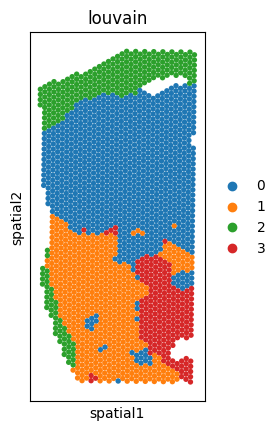

In [14]:
sc.pl.spatial(adata_rna, img_key=None, color=['louvain'],spot_size=80)

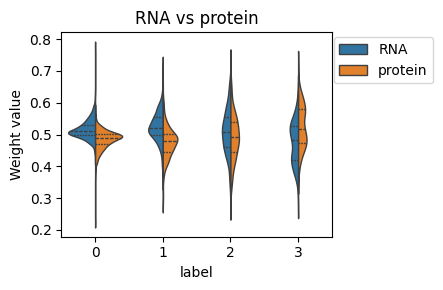

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata_rna.obsm['att'][:, 0], adata_rna.obsm['att'][:, 1]
df['label'] = adata_rna.obs['louvain'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title('RNA vs protein')
ax.set_xlabel('label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')
plt.tight_layout(w_pad=0.05)

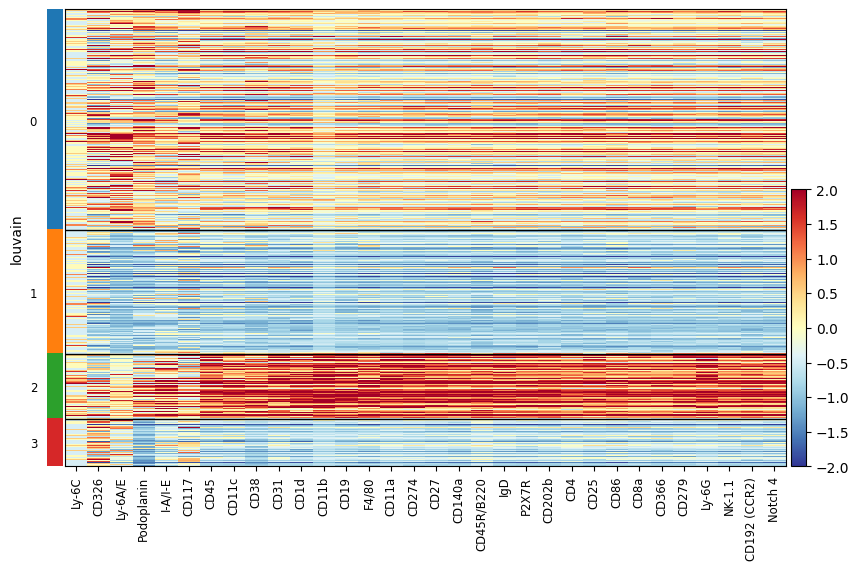

In [18]:

adatas=sc.read('./Data/Dataset_bc/adata_ADT.h5ad')
adatas.obs['louvain'] = adata_rna.obs['louvain']
sc.pp.scale(adatas,max_value=2)
protein=['Ly-6C','CD326','Ly-6A/E','Podoplanin','I-A/I-E','CD117','CD45','CD11c','CD38', 'CD31','CD1d', 'CD11b', 'CD19', 'F4/80','CD11a','CD274','CD27', 'CD140a','CD45R/B220','IgD', 'P2X7R', 'CD202b','CD4','CD25', 'CD86','CD8a', 'CD366', 'CD279', 'Ly-6G', 
           'NK-1.1', 
         'CD192 (CCR2)',    
          'Notch 4',  
        ]

sc.pl.heatmap(adatas,groupby='louvain',var_names=protein ,vmin=-2,cmap='RdYlBu_r',show_gene_labels=True)